# Idea: take the code in src/atmosphere/stochastic_physics used to generate forcing pattern and convert to Python.

Files:
* for_pattern.F90
* SH_spect2grid.F90
* fourier.F90

Notes
* This creates a set of coeffs for sin and cos, and then updates these using an AR(1) process (I believe - see UMDP 081/source code for details).
* Doing this is quite straightforward, but converting these from the coeff values to be on the grid is much harder.
* I cannot do a straight copy of the fortran because it includes an FFT routine that would be super slow in Python.
* Instead, I would have to fully understand it and re-implement in python using standard FFT.
* It involves multiplying by the appropriate (Legendre polynomials) to get a solution on the sphere before carrying out FFT.
* (Legendre polynomials), these are actually the spherical harmonics I think.


In [2]:
import matplotlib.pyplot as plt
import numpy as np

In [3]:
np

<module 'numpy' from '/home/users/mmuetz/miniconda3/envs/mcs_prime_env/lib/python3.10/site-packages/numpy/__init__.py'>

In [4]:
# Taken from code/namelists
planet_radius = 6371229.0
stph_n2 = 60
Lbeta = 500e3
beta  = 0.5*(Lbeta/planet_radius)**2

In [5]:
n = np.arange(1, 61)
n

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60])

In [6]:
pspect = np.exp(-beta * n * (n + 1))

In [7]:
pspect

array([9.93860162e-01, 9.81693348e-01, 9.63721829e-01, 9.40270535e-01,
       9.11757281e-01, 8.78680394e-01, 8.41604241e-01, 8.01143247e-01,
       7.57945049e-01, 7.12673397e-01, 6.65991455e-01, 6.18546066e-01,
       5.70953480e-01, 5.23786959e-01, 4.77566574e-01, 4.32751363e-01,
       3.89733960e-01, 3.48837639e-01, 3.10315672e-01, 2.74352779e-01,
       2.41068408e-01, 2.10521530e-01, 1.82716606e-01, 1.57610376e-01,
       1.35119140e-01, 1.15126214e-01, 9.74892779e-02, 8.20473897e-02,
       6.86274665e-02, 5.70501049e-02, 4.71346417e-02, 3.87034123e-02,
       3.15851966e-02, 2.56178805e-02, 2.06503820e-02, 1.65439141e-02,
       1.31726674e-02, 1.04240015e-02, 8.19823743e-03, 6.40813716e-03,
       4.97815470e-03, 3.84352988e-03, 2.94928958e-03, 2.24920922e-03,
       1.70477699e-03, 1.28419383e-03, 9.61432646e-04, 7.15372817e-04,
       5.29019018e-04, 3.88808203e-04, 2.84004248e-04, 2.06176677e-04,
       1.48757721e-04, 1.06670611e-04, 7.60213066e-05, 5.38457164e-05,
      

In [8]:
std_rand_nos= 1.0 / np.sqrt(12.0)

In [9]:
timestep = 20 * 60 # GUESS! timestep of 20 mins in seconds.
tau_spt = 2.0000e4 # from namelist.
alpha_stoch_tend = 1.0 - np.exp(-timestep/tau_spt)

In [11]:
tmp = 1.0/(2.0 - alpha_stoch_tend)
for i in n:
    tmp = tmp + (2*i+1.0)*pspect[i - 1]**2/(1.0 - 0.5*alpha_stoch_tend)

In [12]:
tmp

167.0686403615014

In [13]:
pspect = pspect / (std_rand_nos * np.sqrt(tmp))

In [14]:
pspect

array([2.66359651e-01, 2.63098882e-01, 2.58282422e-01, 2.51997354e-01,
       2.44355655e-01, 2.35490879e-01, 2.25554278e-01, 2.14710523e-01,
       2.03133183e-01, 1.91000147e-01, 1.78489146e-01, 1.65773537e-01,
       1.53018478e-01, 1.40377607e-01, 1.27990306e-01, 1.15979598e-01,
       1.04450712e-01, 9.34902869e-02, 8.31662010e-02, 7.35279600e-02,
       6.46075769e-02, 5.64208562e-02, 4.89689931e-02, 4.22403938e-02,
       3.62126265e-02, 3.08544192e-02, 2.61276294e-02, 2.19891237e-02,
       1.83925151e-02, 1.52897224e-02, 1.26323271e-02, 1.03727141e-02,
       8.46499563e-03, 6.86572413e-03, 5.53440890e-03, 4.43385432e-03,
       3.53034281e-03, 2.79368619e-03, 2.19716992e-03, 1.71741382e-03,
       1.33417114e-03, 1.03008584e-03, 7.90424823e-04, 6.02799674e-04,
       4.56889029e-04, 3.44170571e-04, 2.57668909e-04, 1.91723605e-04,
       1.41779826e-04, 1.04202604e-04, 7.61146036e-05, 5.52564130e-05,
       3.98678368e-05, 2.85882740e-05, 2.03741024e-05, 1.44309298e-05,
      

In [20]:
alpha = alpha_stoch_tend

In [1]:
# First dim is EW wavespace.
# Second dim is NS wavespace.
coeffc = np.zeros((stph_n2 + 1, stph_n2))
coeffs = np.zeros((stph_n2 + 1, stph_n2))

NameError: name 'np' is not defined

In [26]:
def update_pattern(alpha, coeffc, coeffs, pspect):
    oneminusalpha = 1-alpha
    squarerootalpha = np.sqrt(alpha)
    
    rand_nums = np.random.random((stph_n2 + 1, stph_n2))
    rand_nums2 = np.random.random((stph_n2 + 1, stph_n2))

    #DO n = 1, stph_n2
    #  DO m = 0, n
    #    !  (rand_nums() - 0.5) provides white noise with mean of 0 and var of (1/12)
    #    coeffc(m,n) = oneminusalpha*coeffc(m,n) + squarerootalpha                  &
    #                   *(rand_nums(m,n)-0.5)*pspect(n)#
    #
    #    coeffs(m,n) = oneminusalpha*coeffs(m,n) + squarerootalpha                  &
    #                   *(rand_nums2(m,n)-0.5)*pspect(n)
    #  END DO
    #END DO
    coeffc = oneminusalpha * coeffc + squarerootalpha * (rand_nums - 0.5) * pspect[None, :]
    coeffs = oneminusalpha * coeffc + squarerootalpha * (rand_nums2 - 0.5) * pspect[None, :]
    return coeffc, coeffs

In [27]:
for i in range(10):
    coeffc, coeffs = update_pattern(alpha_stoch_tend, coeffc, coeffs, pspect)

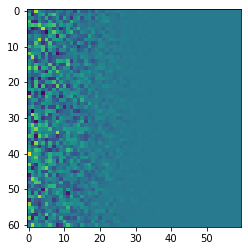

In [28]:
plt.imshow(coeffc)